<a href="https://colab.research.google.com/github/geomyll33/Beautez/blob/master/FInal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [114]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

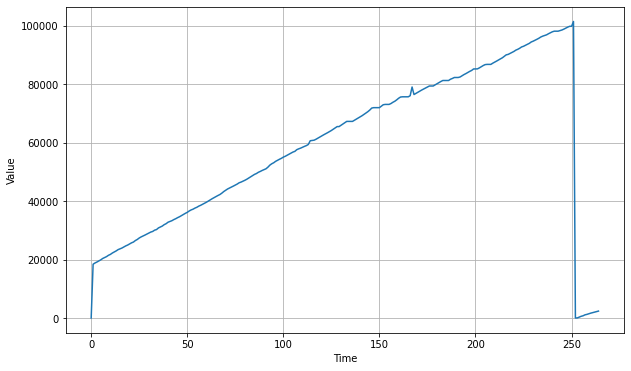

In [115]:
import csv
time_step = []
temps = []

with open('/content/eydap_dataset_527163.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

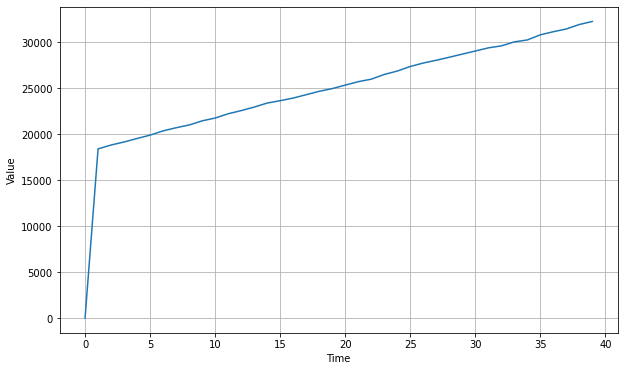

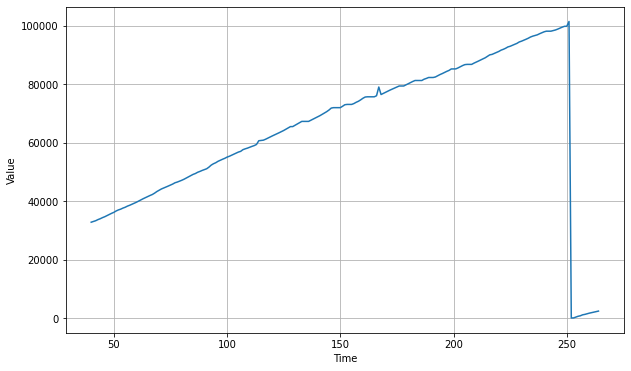

In [158]:
split_time = 40
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 2
batch_size = 12
shuffle_buffer_size = 2
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [159]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

difrent windowing(need to return sequence =false in second lstm

In [160]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [161]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [164]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 
batch_size = 2
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=False),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(40,)
Epoch 1/100
20/20 [==============================] - 3s 4ms/step - loss: 22315.6916 - mae: 22316.1916
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 22309.5284 - mae: 22310.0284
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 22298.0400 - mae: 22298.5400
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 22306.8372 - mae: 22307.3372
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 22304.5570 - mae: 22305.0570
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 22292.0916 - mae: 22292.5916
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 22296.1342 - mae: 22296.6342
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 22285.8446 - mae: 22286.3446
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 22294.3852 - mae:

(1e-08, 0.0001, 0.0, 300.0)

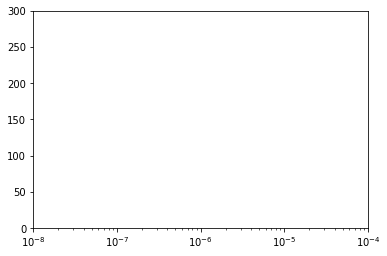

In [112]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 300])

In [139]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=50, batch_size=16, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
2/2 [==============================] - 4s 61ms/step - loss: 31180.6309 - mae: 31181.1296
Epoch 2/150
2/2 [==============================] - 0s 57ms/step - loss: 3979431.0000 - mae: 3979431.5000
Epoch 3/150
2/2 [==============================] - 0s 63ms/step - loss: 21995.2012 - mae: 21995.7012
Epoch 4/150
2/2 [==============================] - 0s 53ms/step - loss: 61304.6328 - mae: 61305.1354
Epoch 5/150
2/2 [==============================] - 0s 52ms/step - loss: 6910.1807 - mae: 6910.6807
Epoch 6/150
2/2 [==============================] - 0s 50ms/step - loss: 6032.1128 - mae: 6032.6128
Epoch 7/150
2/2 [==============================] - 0s 60ms/step - loss: 8749.6006 - mae: 8750.1009
Epoch 8/150
2/2 [==============================] - 0s 54ms/step - loss: 12112.8887 - mae: 12113.3887
Epoch 9/150
2/2 [==============================] - 0s 52ms/step - loss: 9716.5439 - mae: 9717.0446
Epoch 10/150
2/2 [==============================] - 0s 49ms/step - loss: 5637.8846 - mae: 5638.

In [152]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1,]


In [153]:

# do:
mv_f = rnn_forecast[1:]
mv_t = time_valid[:-1]
mv_x = x_valid[:-1]

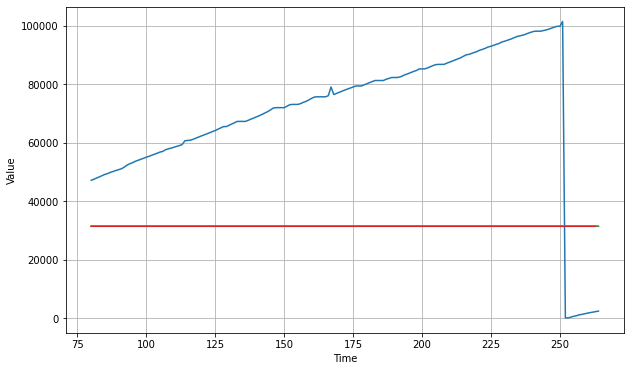

In [154]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plot_series(time_valid, rnn_forecast)
plot_series(mv_t, mv_f)

In [155]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()


43054.34

In [156]:
tf.keras.metrics.mean_absolute_error(mv_x, mv_f).numpy()

43130.496

In [146]:
print(rnn_forecast)

[32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542

In [147]:
print(mv_f)

[32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47 32542.47
 32542.47 32542.47 32542.47 32542.47 32542.47 32542